In [ ]:
import numpy as np
import h5py
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d
import torch

## Get the Dataset from file

In [45]:
filename = "../data/"
rawdata = h5py.File(filename+'ViSAPy_nonfiltered.h5','r')

In [46]:
print(rawdata['data'].shape)

(1200001, 102)


## What is the data?

In [4]:
for i in range(5):
    for j in range(6):
        print(rawdata['data'][i][j], end=" ")
    print("\n")

0.004788064 -0.01826318 0.003492297 -0.032078348 -0.010203197 0.0066871587 

0.0037384066 -0.026971504 -0.0045002163 -0.03491524 -0.007150419 0.012898053 

0.0030027581 -0.025864465 -0.0066695386 -0.029838692 -0.0024219453 0.009391305 

-0.003965647 -0.02545898 -0.00031221227 -0.032533586 -0.0057233935 0.01265745 

-0.009700247 -0.02288886 0.0022615287 -0.01949341 2.8031296e-05 0.012613925 



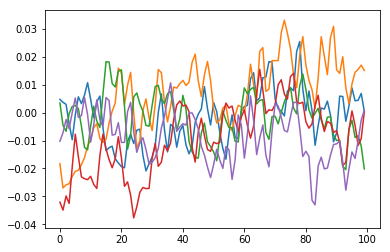

In [5]:
etrode_1 = rawdata['data'][:100, 0]

plt.figure()
for i in range(5):
    etrode_1 = rawdata['data'][:100, i]
    plt.plot(etrode_1)
plt.show()

## Desigining the autoencoder

In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data

torch.cuda.set_device(0)

In [7]:
class autoencoder(nn.Module):
    def __init__(self, input_size):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_size, 1024),
                                     nn.ELU(),
                                     nn.Dropout(p=0.1),
                                     nn.Linear(1024, 512),
                                     nn.ELU(),
                                     nn.Dropout(p=0.1),
                                     nn.Linear(512, 256),
                                     nn.ELU(),
                                     nn.Linear(256,4))
        self.decoder = nn.Sequential(nn.Linear(4, 256),
                                     nn.ELU(),
                                     nn.Linear(256, 512),
                                     nn.ELU(),
                                     nn.Dropout(p=0.1),
                                     nn.Linear(512, 1024),
                                     nn.ELU(),
                                     nn.Linear(1024, input_size),
                                     nn.Tanh())
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec
    
    def forward_numpy(self, x):
        #x = torch.from_numpy(x).float().cuda()
        enc, dec = self.forward(x)
        return dec

In [9]:
import numpy as np

max_length = 100001
length = 100
base_feat_length = 101
features = 200000
np.random.seed(5132)

electrode_data = np.zeros([length, features])

for i in range(features):
    start = np.random.randint(0, max_length)
    selected_trode = np.random.randint(0, base_feat_length)
    electrode_data[:, i] = rawdata['data'][start:start+length, selected_trode]
#print(electrode_data)

In [12]:
#np.save('mydata_100', electrode_data)
#electrode_data = np.load('mydata_100.npy')
#print(electrode_data.shape[1])
train_lim = int(0.8*electrode_data.shape[1])
electrode_data_train = electrode_data[:, :train_lim]
electrode_data_test = electrode_data[:, train_lim:]

160000


In [13]:
import random

def train(model, input_data, criterion, optimizer, epoch_range,  batch_size):
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, input_data.shape[1]), batch_size)
        for feats in selected:
            x = input_data[:, feats]
            #print(x)
            x = np.append(x, 1)
            x = torch.from_numpy(x).float().cuda()
            #---------FORWARD------------#
            out = model.forward_numpy(x)
            out = torch.tensor(out).float().cuda()
            #print(type(torch.from_numpy(out).float().cuda()), type(x))
            loss = criterion(out, x)
            #print(loss)
            #---------BACKWARD------------#
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print('epoch [{}/{}], loss:{:.7f}'.format(num_epoch + 1, epoch_range, loss.data[0]))
    return out

In [19]:
epoch_range = 50
batch_size = 500
learning_rate = 0.00001

model = autoencoder(length+1).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate)

out = train(model, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

/home/sambit/anaconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [1/50], loss:0.0005465
epoch [2/50], loss:0.0004623
epoch [3/50], loss:0.0005907
epoch [4/50], loss:0.0003637
epoch [5/50], loss:0.0003569
epoch [6/50], loss:0.0004496
epoch [7/50], loss:0.0001941
epoch [8/50], loss:0.0003222
epoch [9/50], loss:0.0003146
epoch [10/50], loss:0.0001845
epoch [11/50], loss:0.0001782
epoch [12/50], loss:0.0001313
epoch [13/50], loss:0.0004058
epoch [14/50], loss:0.0001731
epoch [15/50], loss:0.0001273
epoch [16/50], loss:0.0001490
epoch [17/50], loss:0.0001514
epoch [18/50], loss:0.0000680
epoch [19/50], loss:0.0002671
epoch [20/50], loss:0.0001166
epoch [21/50], loss:0.0001060
epoch [22/50], loss:0.0003105
epoch [23/50], loss:0.0001699
epoch [24/50], loss:0.0001259
epoch [25/50], loss:0.0000961
epoch [26/50], loss:0.0001318
epoch [27/50], loss:0.0001034
epoch [28/50], loss:0.0000946
epoch [29/50], loss:0.0006217
epoch [30/50], loss:0.0001161
epoch [31/50], loss:0.0003273
epoch [32/50], loss:0.0000694
epoch [33/50], loss:0.0000829
epoch [34/50], loss

In [20]:
out = (out.data).cpu().numpy()
print(out.shape)

(101,)


/home/sambit/anaconda3/envs/deeplearning/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


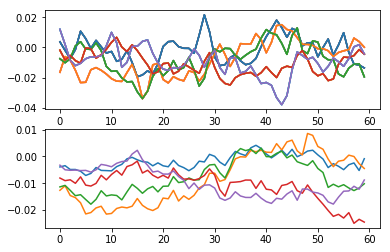

In [67]:
n = [1, 30, 45, 50, 65]
lim = 60
# input_list = []
# output_list = []
for i in n:
    data = electrode_data_test[:100, i]
#     input_list.append(data)
    data = np.append(data, 1)
    #print(data)
    data = torch.from_numpy(data).float().cuda()
    o = model.forward_numpy(data).cuda()
    o = (o.data).cpu().numpy()
#     output_list.append(o[:100])
    #print(electrode_data[:30, 0]-o[:30])
    #print(o)
    plt.subplot(211)
    plt.plot(electrode_data_test[:lim, n])
    plt.subplot(212)
    plt.plot(o[:lim])
plt.show()

In [44]:
from scipy.interpolate import interp1d

def downsample_by_interp(shape, jitter_size):
    x = np.arange(len(shape))
    down_x = x[::3]
    intrp = interp1d(x, shape, 'cubic', fill_value='extrapolate')
    return intrp(down_x + (np.random.random()-.5)*jitter_size)

down_sampled = 

downsampled = np.array([downsample_by_interp(s, 3) for s in train_data])
print(downsampled.shape)

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  